# Bioinformatics Hackathon

In [75]:
import os.path as path
from pathlib import Path

import numpy as np
import pandas as pd

import anndata as ad
import scanpy as sc
import squidpy as sq

import csv
import gzip
import os
import scipy.io
import scipy.ndimage

from cellpose import models, io, utils

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from skimage.measure import regionprops
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

cd = Path(path.abspath(""))

# Part 1: Reading Transcriptomic Data

Here, we read the Visium feature-barcode matrix, which tells us the level of gene expression at each spatial point on the Visium image. (I think)

In [18]:
matrix_dir_path = os.path.join(cd, "resources", "ovarian cancer", "filtered_feature_bc_matrix")
mat_filtered = scipy.io.mmread(path.join(matrix_dir_path, "matrix.mtx.gz"))

# list of transcript ids, e.g. 'ENSG00000187634'
features_path = path.join(matrix_dir_path, "features.tsv.gz")
feature_ids = [row[0]  for row  in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]

# list of gene names, e.g. 'SAMD11'
gene_names = [row[1]  for row  in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]

# list of feature_types, e.g. 'Gene Expression'
feature_types = [row[2]  for row  in csv.reader(gzip.open(features_path, mode="rt"), delimiter="\t")]

# list of barcodes, e.g. 'AAACATACAAAACG-1'
barcodes_path = os.path.join(matrix_dir_path, "barcodes.tsv.gz")
barcodes = [row[0]  for row  in csv.reader(gzip.open(barcodes_path, mode="rt"), delimiter="\t")]


Now, we load the decompressed data into a single combined feature-barcode matrix for easier processing.

In [19]:
fbc_matrix = pd.DataFrame.sparse.from_spmatrix(mat_filtered)
fbc_matrix.columns = barcodes
fbc_matrix.insert(loc=0, column="feature_id", value=feature_ids)
fbc_matrix.insert(loc=1, column="gene", value=gene_names)
fbc_matrix.insert(loc=2, column="feature_type", value=feature_types)

In [20]:
fbc_matrix

,feature_id,gene,feature_type,AACAATGTGCTCCGAG-1,AACACCATTCGCATAC-1,AACACGTTGATACCGC-1,AACACTCGTGAGCTTC-1,AACAGCCTCCTGACTA-1,AACAGGAATTCTGTGA-1,AACAGGATGCTGGCAT-1,...,TGTTCCAATCTAATTG-1,TGTTCGATGGATACGT-1,TGTTCGTGGCGTCGTG-1,TGTTCTCCTGCAATTA-1,TGTTGCCAGTCGCCTG-1,TGTTGCTATCGGTGGC-1,TGTTGGCCTGTAGCGG-1,TGTTGGTGCGCACGAG-1,TGTTGGTGCGGAATCA-1,TGTTGGTGGACTCAGG-1
0,ENSG00000187634,SAMD11,Gene Expression,3,3,5,13,12,4,14,...,6,11,0,18,4,3,4,5,11,19
1,ENSG00000188976,NOC2L,Gene Expression,12,5,6,6,9,5,8,...,6,7,0,22,1,7,10,0,18,14
2,ENSG00000187961,KLHL17,Gene Expression,0,1,3,2,0,2,1,...,2,1,0,1,0,1,1,0,2,1
3,ENSG00000187583,PLEKHN1,Gene Expression,0,2,0,2,2,0,1,...,3,2,0,0,0,0,2,0,4,2
4,ENSG00000187642,PERM1,Gene Expression,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18080,ENSG00000212907,MT-ND4L,Gene Expression,79,69,108,61,83,58,61,...,55,77,8,237,53,92,153,6,98,149
18081,ENSG00000198886,MT-ND4,Gene Expression,117,83,163,187,179,104,76,...,194,98,7,331,79,112,210,10,192,308
18082,ENSG00000198786,MT-ND5,Gene Expression,22,5,29,25,39,1,4,...,24,3,3,42,7,27,15,2,28,34
18083,ENSG00000198695,MT-ND6,Gene Expression,8,9,7,15,18,8,3,...,5,3,1,38,8,8,10,0,18,22


# Part 2: Cell Segmentation and Morphological Clustering
Now that we have the transcriptomic data, we will load in the corresponding high-res Visium image and perform cell segmentation on it. The resulting cells will then be clustered through KMeans based on morphological features such as area, perimeter, and eccentricity.

In [124]:
# Segment cells
# masks contain the segmented masks of cells
# flows contain the vector fields used for segmentation
# styles contain the size and scale of the cells
# diams contain the estimated diameters of the cells
def segment_cells(model_type, cio_image):
    model = models.Cellpose(model_type=model_type)
    masks, flows, styles, diams = model.eval(cio_image)
    return masks

# Extract morphological features from segmented masks
def extract_morphological_features(masks):
    features = []
    coords = []
    # Compute connected components and regionprops
    labelled_mask, num_labels = scipy.ndimage.label(masks)
    props = regionprops(labelled_mask)

    # Extract morphological features from regionprops
    for region in props:
        # Example: area, perimeter, eccentricity
        area = region.area
        perimeter = region.perimeter
        eccentricity = region.eccentricity
        region_coords = region.coords

        # Add features to the list
        features.append([area, perimeter, eccentricity])
        coords.append(region_coords)

    return np.array(features), np.array(coords)

def cluster_features(k, features):
    kmeans = KMeans(n_clusters=k)
    return kmeans.fit_predict(features)

def generate_clustered_bitmap(img_width, img_height, labels, coords):
    empty_label = np.unique(labels).size + 1
    cluster_bitmap = [[empty_label for w in range(img_width)] for h in range(img_height)]

    for i in range(len(labels)):
        label = labels[i]
        label_coords = coords[i]
        for c in label_coords:
            cluster_bitmap[c[0]][c[1]] = label
    
    return cluster_bitmap

In [126]:
model_types = ["nuclei", "cyto", "cyto2", "cyto3", "tissuenet_cp3"]

image_path = path.join(cd, "resources", "ovarian cancer", "spatial", "tissue_hires_image.png")
cio_image = io.imread(image_path)

cmap = ListedColormap(["tab:red", "tab:blue", "tab:green", "tab:orange", "tab:purple"])

img_width = cio_image.shape[0]
img_height = cio_image.shape[1]

results = {}

for model_type in model_types:
    this_results = {}

    masks = segment_cells(model_type, cio_image)
    morphological_features, coords = extract_morphological_features(masks)

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(morphological_features)

    cluster_labels = cluster_features(5, scaled_features)

    clustered_bitmap = generate_clustered_bitmap(img_height, img_width, cluster_labels, coords)

    this_results["masks"] = masks
    this_results["morphological_features"] = morphological_features
    this_results["coords"] = coords
    this_results["scaled_features"] = scaled_features
    this_results["cluster_labels"] = cluster_labels
    this_results["clustered_bitmap"] = clustered_bitmap

    results[model_type] = this_results

/var/folders/sl/_wx2y47s4k37vl90jtllnc8h0000gn/T/ipykernel_968/3423301737.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features), np.array(coords)
/var/folders/sl/_wx2y47s4k37vl90jtllnc8h0000gn/T/ipykernel_968/3423301737.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(features), np.array(coords)
/var/folders/sl/_wx2y47s4k37vl90jtllnc8h0000gn/T/ipykernel_968/3423301737.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays 

HTTPError: HTTP Error 500: INTERNAL SERVER ERROR

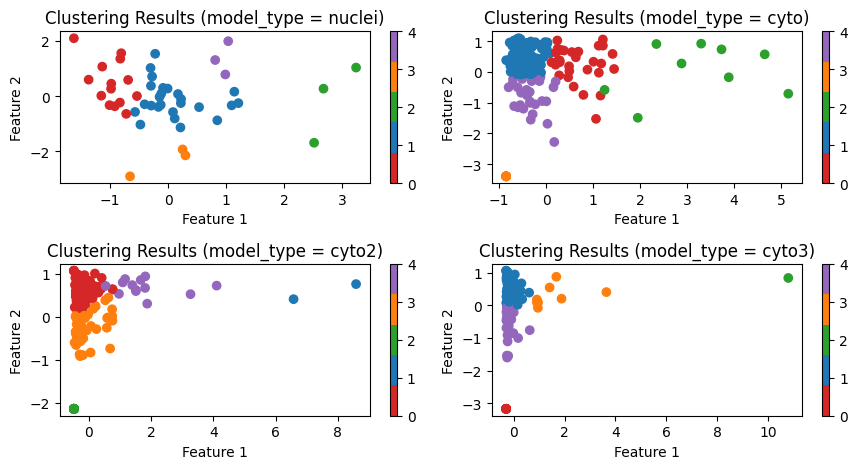

In [ ]:
fig, ax = plt.subplots(3, 2)
fig.set_figwidth(9)

subplots = ax.reshape(-1)

# Visualize the clustering results
for i in range(len(model_types)):
    model = model_types[i]
    a = subplots[i]
    scaled_features = results[model]["scaled_features"]
    cluster_labels = results[model]["cluster_labels"]
    p = a.scatter(scaled_features[:, 0], scaled_features[:, 2], c=cluster_labels, cmap=cmap)
    a.set_xlabel('Feature 1')
    a.set_ylabel('Feature 2')
    a.set_title(f'Clustering Results (model_type = {model})')
    cb = fig.colorbar(p)
    cb.set_ticks([0, 1, 2, 3, 4])

plt.tight_layout()
plt.show()

Finally, we will be visualising the cell segmentation with these clusters.

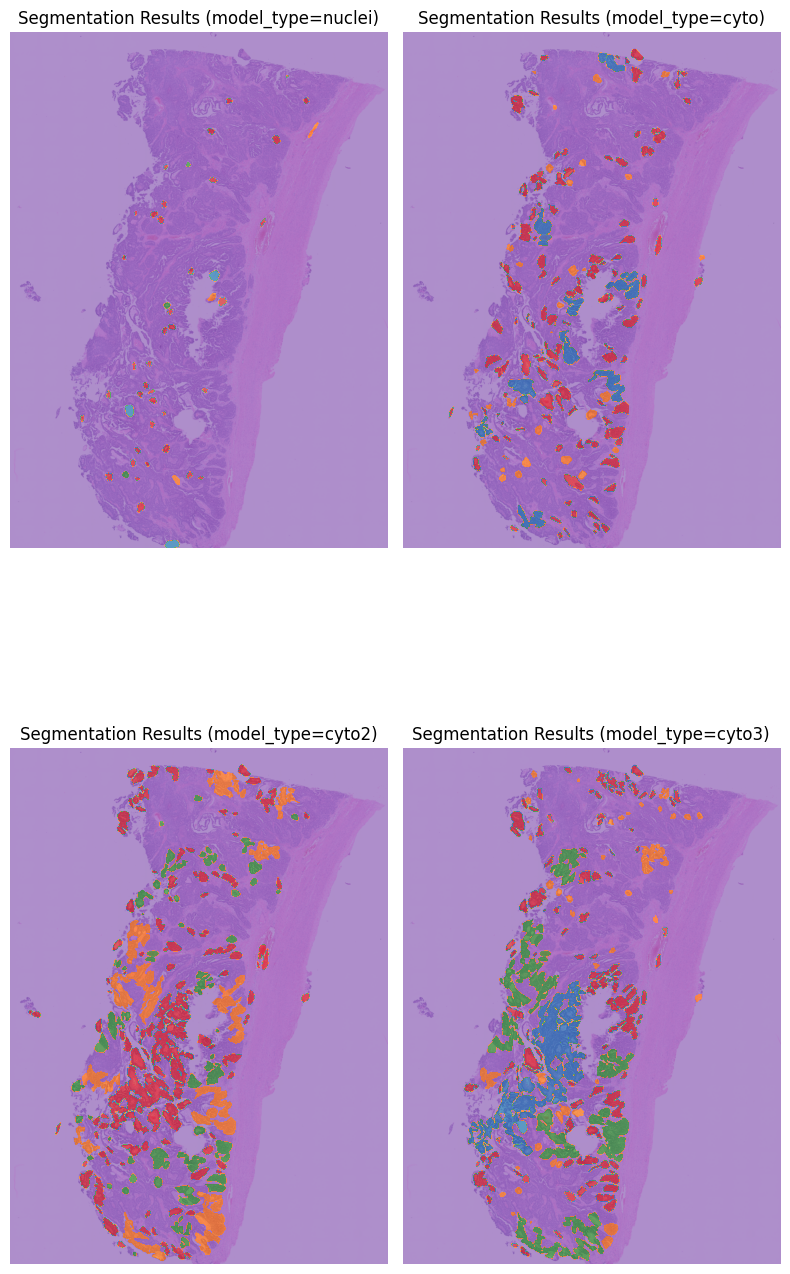

In [ ]:
image = plt.imread(image_path)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(8, 16))
subplots = ax.reshape(-1)

# Visualize the clustered segmented cells over the actual image
for i in range(len(model_types)):
    model = model_types[i]
    a = subplots[i]
    a.imshow(image)
    a.imshow(results[model]["clustered_bitmap"], alpha=0.7, cmap=cmap)
    a.set_title(f"Segmentation Results (model_type={model})")
    a.axis('off')

plt.tight_layout()
plt.show()

# Part 3: Combining Results

Now that we have transcriptomic data with spatial context (Part 1) and morphological data with spatial context (Part 2), let us compare these to see if there is any correlation.